In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2023-06-14 21:17:34.660116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = os.getcwd() + "/image_data"
path

'/root/image_data'

In [3]:
TRAINING_DIR = path+"/train"
VALIDATION_DIR = path + "/val"
TEST_DIR = path + "/test"

print(TRAINING_DIR)
print(VALIDATION_DIR)
print(TEST_DIR)

/root/image_data/train
/root/image_data/val
/root/image_data/test


In [4]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  train_datagen = ImageDataGenerator(rescale=1.0/255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=128,
                                                      class_mode="binary",
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator(rescale=1.0/255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=128,
                                                                class_mode="binary",
                                                                target_size=(224, 224))
  test_datagen = ImageDataGenerator(rescale=1.0/255)
  
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                    batch_size=128,
                                                    class_mode="binary",
                                                    target_size=(224, 224))
  return train_generator, validation_generator, test_generator

In [5]:
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

class_names = train_generator.class_indices
print(class_names)

Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
{'Queen': 0, 'Queenless': 1}


In [6]:
img1, img2 = train_generator[0][:2]

In [7]:
# fig, ax = plt.subplots(2,3, figsize=(10,8))

# ax[0].plot(img1, x_axis='time')

In [8]:
model = keras.Sequential([
    layers.Conv2D(16, (3,3), activation = "elu", input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation = "elu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = "elu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation = "elu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(256, (3,3), activation = "elu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(512, (3,3), activation = "elu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1024, activation = "elu"),
    layers.Dropout(0.2),
    layers.Dense(512, activation = "elu"),    
    layers.Dense(1, activation = "sigmoid")               
])

2023-06-14 21:17:43.214723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21286 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# tf.keras.losses.BinaryCrossentropy()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [10]:
earlystopper = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [11]:
epochs = 23
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks = [earlystopper]
)

Epoch 1/23


2023-06-14 21:17:46.147498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-14 21:17:48.281552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-14 21:17:53.001658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-14 21:17:55.174016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-14 21:17:55.177672: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1f968a90 initia

110/110 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.5219

2023-06-14 21:20:45.493335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


110/110 [==============================] - 203s 2s/step - loss: 0.7456 - accuracy: 0.5219 - val_loss: 0.6896 - val_accuracy: 0.5010
Epoch 2/23
110/110 [==============================] - 188s 2s/step - loss: 0.6941 - accuracy: 0.5656 - val_loss: 0.6909 - val_accuracy: 0.4915
Epoch 3/23
110/110 [==============================] - 192s 2s/step - loss: 0.6202 - accuracy: 0.6574 - val_loss: 0.5801 - val_accuracy: 0.7075
Epoch 4/23
110/110 [==============================] - 191s 2s/step - loss: 0.5425 - accuracy: 0.7311 - val_loss: 0.5422 - val_accuracy: 0.7320
Epoch 5/23
110/110 [==============================] - 188s 2s/step - loss: 0.5111 - accuracy: 0.7529 - val_loss: 0.5224 - val_accuracy: 0.7490
Epoch 6/23
110/110 [==============================] - 189s 2s/step - loss: 0.4755 - accuracy: 0.7827 - val_loss: 0.4667 - val_accuracy: 0.7770
Epoch 7/23
110/110 [==============================] - 186s 2s/step - loss: 0.4557 - accuracy: 0.7857 - val_loss: 0.4774 - val_accuracy: 0.7765
Epoch 8/23

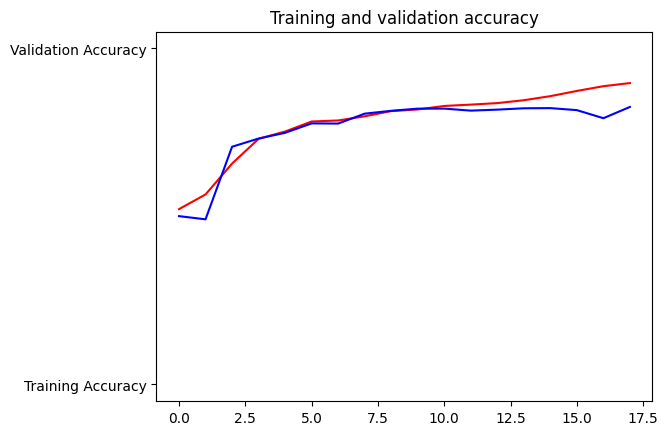

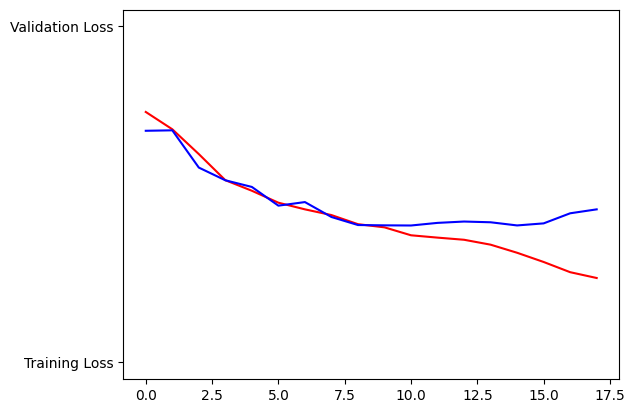

In [12]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [13]:
test_predict = model.predict(test_generator)

2023-06-14 22:14:22.970480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 48s 1s/step


In [14]:
show_test_predict = np.round(test_predict, 0)
show_test_predict = pd.DataFrame(show_test_predict)
print(show_test_predict)
print(len(show_test_predict))

        0
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
...   ...
3995  0.0
3996  1.0
3997  1.0
3998  1.0
3999  0.0

[4000 rows x 1 columns]
4000


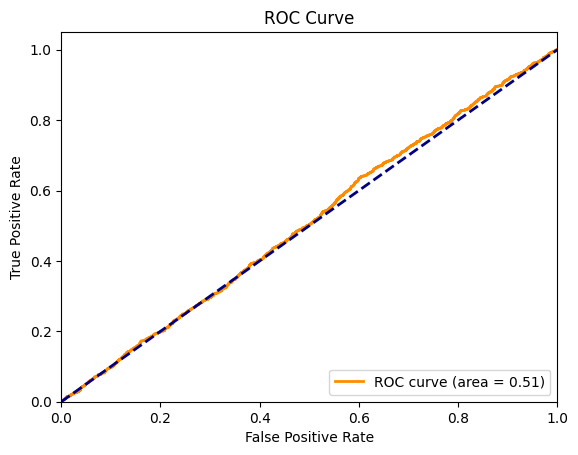

In [15]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_generator.classes, test_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [16]:
from sklearn.metrics import f1_score
f1_score(test_generator.classes, show_test_predict, average='macro')

0.5024905503235314

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes, show_test_predict)

array([[1070,  930],
       [1058,  942]])

In [18]:
model.evaluate(test_generator)

2023-06-14 22:15:13.884503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 47s 1s/step - loss: 0.3973 - accuracy: 0.8180


[0.39734503626823425, 0.8180000185966492]

In [19]:
# os.chdir("D:\\Study\\Code\\Python\\2023Sound_Classification_Bee_Qeen_Queenless\\Models")
model.save("CNN.h5")

In [20]:
# STFT, Chroma
# C1:using wavelet --> Feature selection
# C2: MFCC --> spectral --> vector(using average) --> feature selection --> ML(KNN, SVM, Logistic)
# C3: HHT --> spectral --> average --> HHT 
# ==> Apply DL, ML
## => Comparison(time, accuracy,...)

In [21]:
# Chossing dataset 
# Date
# Time [~m --> ~m]